# Analysing FORC Data
Assuming an Input as multiple csv files (with a space as separator) like the following Table:  
<table><thead><tr><th>$H_{ext}$</th><th>$V_H$</th></tr>
    <tr><th>units</th><th>units</th></tr></thead>
    <tr><td>$H_0$</td><td>$V_0$</td></tr>
    <tr><td>$H_i$</td><td>$V_i$</td></tr>
    <tr><td>$H_N$</td><td>$V_N$</td></tr>
</table>
The unit row is being ignored by this script.
Optional a third row with the temperature is valid (need to change code in the end).
Adjust `folder` to the place where you've put your `*.dat` files.
$V_i$ will be devided by `current` to determine the resistance $R_i$.

## File structure
The csv input files should use the following naming convention:
* Every File contains `HA=` in the name to determine the reversal Field $H_A$
 * Immediately after `HA=` must be the field value followed by `.dat`
* Down Sweeps: contain the word `down_to` in the name and will be ignored
* Saturation Measurements at $H_S$ (containing only information about the saturation field value): contain the word `_sat_`
* All other files are up sweeps from $H_A$ to $H_S$

### Example
```
Some_Ignored_Informations_down_to_HA=1.500000.dat
Some_Ignored_Informations_sat_HA=1.500000.dat
Some_Ignored_Informations_upinformation_HA=1.500000.dat
Some_Ignored_Informations_down_to_HA=0.000000.dat
Some_Ignored_Informations_sat_HA=0.000000.dat
Some_Ignored_Informations_upinformation_HA=0.000000.dat
Some_Ignored_Informations_down_to_HA=-1.500000.dat
Some_Ignored_Informations_sat_HA=-1.500000.dat
Some_Ignored_Informations_upinformation_HA=-1.500000.dat
```

## Output
The output will be a file `output.dat` which contains a header that is readable by FORCinel and a Table like the following:
<table width=200px>
    <tr><td>$\langle H_S\rangle$</td><td>$\langle R_S \rangle$</td></tr>
    <tr><td>$H_{A_1}$</td><td>$R(H_{A_1})$</td></tr>
    <tr><td>$H_S$</td><td>$R(H_S)$</td></tr>
    <tr><td></td><td></td></tr>
    <tr><td>$\langle H_S\rangle$</td><td>$\langle R_S \rangle$</td></tr>
    <tr><td>$H_{A_2}$</td><td>$R(H_{A_2})$</td></tr>
    <tr><td>$H_{i}$</td><td>$R(H_i)$</td></tr>
    <tr><td>$H_S$</td><td>$R(H_S)$</td></tr>
</table>
With 2 entries for the first reversal field $H_{A_1}$ and one more entry with each following reversal field (ordered by the magnitude of the reversal fields starting at $\max(H_{A_i})$ and ending at $\min(H_{A_i})$)

### Example
```
MicroMag 2900/3900 Data File (Series 0015)
First-order reversal curves
Configuration   :  VSM
Hardware version:  0004
Software version:  11/20/2006
Units of measure:  mks
Temperature in  :  Kelvin
01/11/2007  15:01
bg1.11 frag c.03 taped sample forc

Averaging time = +1.000000E-01
Hb1            = -1.000000E+03
Hb2            = +1.000000E+03
Hc1            =  0.000000E+00
Hc2            = +3.000000E+03
HCal           = +1.500000E-01
HNcr           = +2.000005E-03
HSat           = +1.500000E-01
NCrv           = 100
PauseCal       = +1.000000E+00
PauseNtl       = +1.000000E+00
PauseSat       = +1.000000E+00
SlewRate       = +1.000000E+04
Smoothing      = 5

Field range    = +1.500000E-01
Moment range   = +1.000000E-02
Temperature    = +0.000000E+00
Orientation    = +9.000001E+01
Elapsed time   = +6.436355E+06
Slope corr.    = N/A
Saturation     = N/A
NData          = 5250

1.500000E+02,1.320206E+00

+4.820400E+01,+1.226155E+00
+1.500000E+02,+1.320205E+00

1.500000E+02,1.320204E+00

+4.620800E+01,+1.221773E+00
+9.810400E+01,+1.293156E+00
+1.500000E+02,+1.320204E+00

1.500000E+02,1.320207E+00

+4.421200E+01,+1.217202E+00
+7.947467E+01,+1.275475E+00
+1.147373E+02,+1.304538E+00
+1.500000E+02,+1.320206E+00
```

In [1]:
__author__ = 'Jonathan Pieper'
__license__ = 'tbd'
__version__ = '0.1'
__status__ = "Development"

import os, sys, time
from glob import glob
import pylab as plt
import numpy as np
from scipy import stats
import pandas as pd
from scipy.interpolate import interp1d 

folder = "C:\\Users\\user\\Documents\\cubes_theta_0deg"
header = ['H', 'V']  # Column names
current = 1 #2.5e-6
fit_data = True  # Fitting gradiometry data (subtracting linear fit)
out_name = "output.dat"

In [2]:
def get_filenames(datadir):
    """Returns all *.dat files in data directory"""
    os.chdir(datadir)
    return glob("*.dat")

def sort_files(filenames):
    """Sorting files by filename key HA"""
    sort_dict = {}
    saturation_dict = {}
    for f in filenames:
        if(f.find("HA=") == -1 or    # File must have HA=
           f.find("down_to") != -1):  # File musn't have down_to
            continue
        
        pos1 = f.find("HA=") + 3 # Cursor Position after HA=
        pos2 = f.find(".dat")    # Cursor Position before .dat
        HA = float(f[pos1:pos2]) # Number between cursor positions
        
        if(f.find("_sat_") != -1): # Saturation for Average
            saturation_dict[HA] = f
        else:    # Up-Sweeps
            sort_dict[HA] = f

    new_filenames = []
    saturation = []
    for HA in sorted(sort_dict):
        new_filenames.append(sort_dict[HA])
        saturation.append(saturation_dict[HA])
    new_filenames.reverse() # From + to -
    saturation.reverse() # From + to -
        
    return new_filenames, saturation

def load_file(filename):
    """Loading File into an Array"""
    data = np.genfromtxt(filename, skip_footer=1, skip_header=5, delimiter='\t')
    return data

def write(name, H, R, T, sat):
    """Writing results into file"""
    len_data = len(H)
    for i in range(len(H)):
        len_data += i+2
    num_curves = len(H)
    
    if not T:
        Temp = 0
    else:
        Temp = T[0][0]

    f = open(name, 'w')
    f.write('MicroMag 2900/3900 Data File (Series 0015)\n' + 
'First-order reversal curves\n' +
'Configuration   :  VSM\n' +
'Hardware version:  0004\n' + 
'Software version:  11/20/2006\n' + 
'Units of measure:  mks\n' +
'Temperature in  :  Kelvin\n' +
'01/11/2007  15:01\n' +
'bg1.11 frag c.03 taped sample forc\n'+
'\n'+
'Averaging time = +1.000000E-01\n' +
'Hb1            = -1.000000E+03\n' +
'Hb2            = +1.000000E+03\n' +
'Hc1            =  0.000000E+00\n' +
'Hc2            = +3.000000E+03\n' +
'HCal           = +1.500000E-01\n' +
'HNcr           = +2.000005E-03\n' +
'HSat           = +1.500000E-01\n' +
'NCrv           = %d\n' % (num_curves) +
'PauseCal       = +1.000000E+00\n' +
'PauseNtl       = +1.000000E+00\n' +
'PauseSat       = +1.000000E+00\n' +
'SlewRate       = +1.000000E+04\n' +
'Smoothing      = 5\n' +
'\n' +
'Field range    = +1.500000E-01\n' +
'Moment range   = +1.000000E-02\n' +
'Temperature    = +%.6E\n' % (Temp) +
'Orientation    = +9.000001E+01\n' +
'Elapsed time   = +6.436355E+06\n' +
'Slope corr.    = N/A\n' +
'Saturation     = N/A\n' +
'NData          = %d\n' % (len_data))

    fig = plt.figure()
    for i in range(len(H)):
        c = np.linspace(H[i][0], H[i][-1], i+2)
        # c = Array between beginning and end H with i+2 values.
        f1 = interp1d(H[i], R[i], kind = 'linear')
        if T:
            t = interp1d(H[i], T[i], kind = 'linear')
        y=[]
        if not T:
            f.write('\n%.6E,%.6E\n\n' % (H[i][-1],sat[i]))
        else:
            f.write('\n%.6E,%.6E,%.6E\n\n' % (H[i][-1],sat[i],T[i][-1]))
        for k in range(len(c)):
            val = f1(c[k])
            y.append(val)
            if not T:
                f.write('%+.6E,%+.6E\n' % (c[k], val))
            else:
                f.write('%+.6E,%+.6E,%+.6E\n' % (c[k], val, t(c[k])))

        plt.plot(c, y, linestyle="solid", marker=".")

#    for i in range(len(H)):
#        f.write("\n%.5E,%.5E,%.5E\n\n" % (.15, sat[i], T[i][0]))
#        for j in range(len(H[i])):
#            f.write("%.5E,%.5E,%.5E\n" % (H[i][j], R[i][j], T[i][j]))
    f.close()
    
    plt.xlabel("$\mu_0 H$")
    plt.ylabel("$R_H$")

In [3]:
def cut_data(data):
    """Cuts off the first and last values that are equal.
    Returns Index of first and last value.
    e.g.: [1,1,1,.5,0,0,0] -> (2, 4)"""
    min_A = max_A = 0

    if(data[0] == data[1]):
        for i in range(len(data)):
            if data[i] == data[i+1]:
                min_A += 1
            else:
                break

    if(data[-1] == data[-2]):
        for i in range(len(data)-1):
            if data[-(i+1)] == data[-(i+2)]:
                max_A += 1
            else:
                break
    return min_A, -max_A

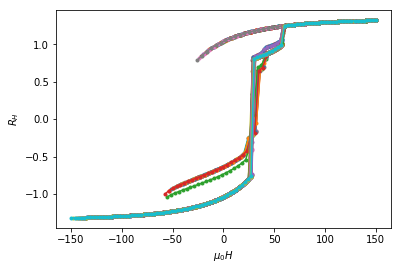

In [4]:
all_files = get_filenames(folder)
all_files_sorted, saturation = sort_files(all_files)
#fig = plt.figure()
H_list = []
R_list = []
T_list = []
for f in all_files_sorted:
    data = pd.read_csv(f, sep=' ', header=2, names=header, index_col=False)
    H = np.array(data.H)
    V = np.array(data.V)
    
    if fit_data:
        fit_area = data[data.H < data.H.min() + 150]
        fit = scipy.stats.linregress(fit_area.H, fit_area.H)
        fitting_line = (data.H*fit.slope + fit.intercept)
        V = V - fitting_line
        
    #data = filehandler.load_file(f)
    #H = [data[i][H_idx] for i in np.arange(len(data))]
    #V = [data[i][V_idx] for i in np.arange(len(data))]
    #T = [data[i][T_idx] for i in np.arange(len(data))]

    # Cut of unneccessary data and calculate R_H
    #min_H, max_H = cut_data(H)
    #H = np.array(H[min_H:max_H])
    #V = np.array(V[min_H:max_H])
    #T = np.array(T[min_H:max_H])
    R = V/current

    H_list.append(H)
    R_list.append(R)
    #T_list.append(T)

    #plt.plot(list(H) ,list(R))

sat_avg = []
for sat in saturation:
    sat_data = pd.read_csv(sat, sep=' ', header=2, names=header, index_col=False)
    sat_V = np.array(sat_data.V)
    sat_R = sat_V/current

    sat_avg.append(np.average(sat_R))

write(out_name, H_list, R_list, T_list, sat_avg)

plt.show()